In [17]:
import pandas as pd
import numpy as np
import igraph as ig
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt

In [18]:
classes_path = "../elliptic_bitcoin_dataset/elliptic_txs_classes.csv"
edges_path = "../elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv"
features_path = "../elliptic_bitcoin_dataset/elliptic_txs_features.csv"

classes = pd.read_csv(classes_path)
edges = pd.read_csv(edges_path)
feat_cols = ['txId', 'time_step'] + [f'trans_feat_{i}' for i in range(93)] + [f'agg_feat_{i}' for i in range(72)]
feats = pd.read_csv(features_path, header=None, names=feat_cols)
classes.columns = ['txId', 'label']
df = classes.set_index('txId').join(feats.set_index('txId'))
df.head(10)

,label,time_step,trans_feat_0,trans_feat_1,trans_feat_2,trans_feat_3,trans_feat_4,trans_feat_5,trans_feat_6,trans_feat_7,...,agg_feat_62,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71
txId,,,,,,,,,,,,,,,,,,,,,
230425980,unknown,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
5530458,unknown,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
232022460,unknown,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
232438397,2,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
230460314,unknown,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117
230459870,unknown,1,0.961040,-0.081127,-1.201369,1.303743,0.333276,1.480381,-0.061584,-0.163577,...,-0.504702,-0.422589,-0.226790,-0.117629,0.018279,0.277775,0.413931,1.149556,-0.696053,-0.695540
230333930,unknown,1,-0.171264,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.161887,...,-0.569626,-0.607306,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
230595899,unknown,1,-0.171755,-0.184668,-1.201369,-0.046932,-0.043875,-0.029140,-0.061584,-0.163552,...,0.969801,0.704641,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
232013274,unknown,1,-0.123127,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.112635,...,-0.128722,-0.235168,-0.979074,-0.978556,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399


In [19]:
label_colors = {'1':'red', '2':'green', 'unknown':'white'}

tx_graph = ig.Graph(directed=False)

edges_dict = {tx_id: i for i, tx_id in enumerate(classes['txId'])}

tx_graph.add_vertices(len(classes))
tx_graph.vs['id'] = list(classes['txId'])
tx_graph.vs['type'] = list(classes['label'])
tx_graph.vs['time_step'] = list(feats['time_step'])
tx_graph.vs['color'] = [label_colors[label] for label in classes['label']]

edges_list = [(edges_dict[edges['txId1'][i]], edges_dict[edges['txId2'][i]]) for i in tqdm(range(len(edges)))]
tx_graph.add_edges(edges_list)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 234355/234355 [00:00<00:00, 325718.36it/s]


In [21]:
centralities = tx_graph.closeness()

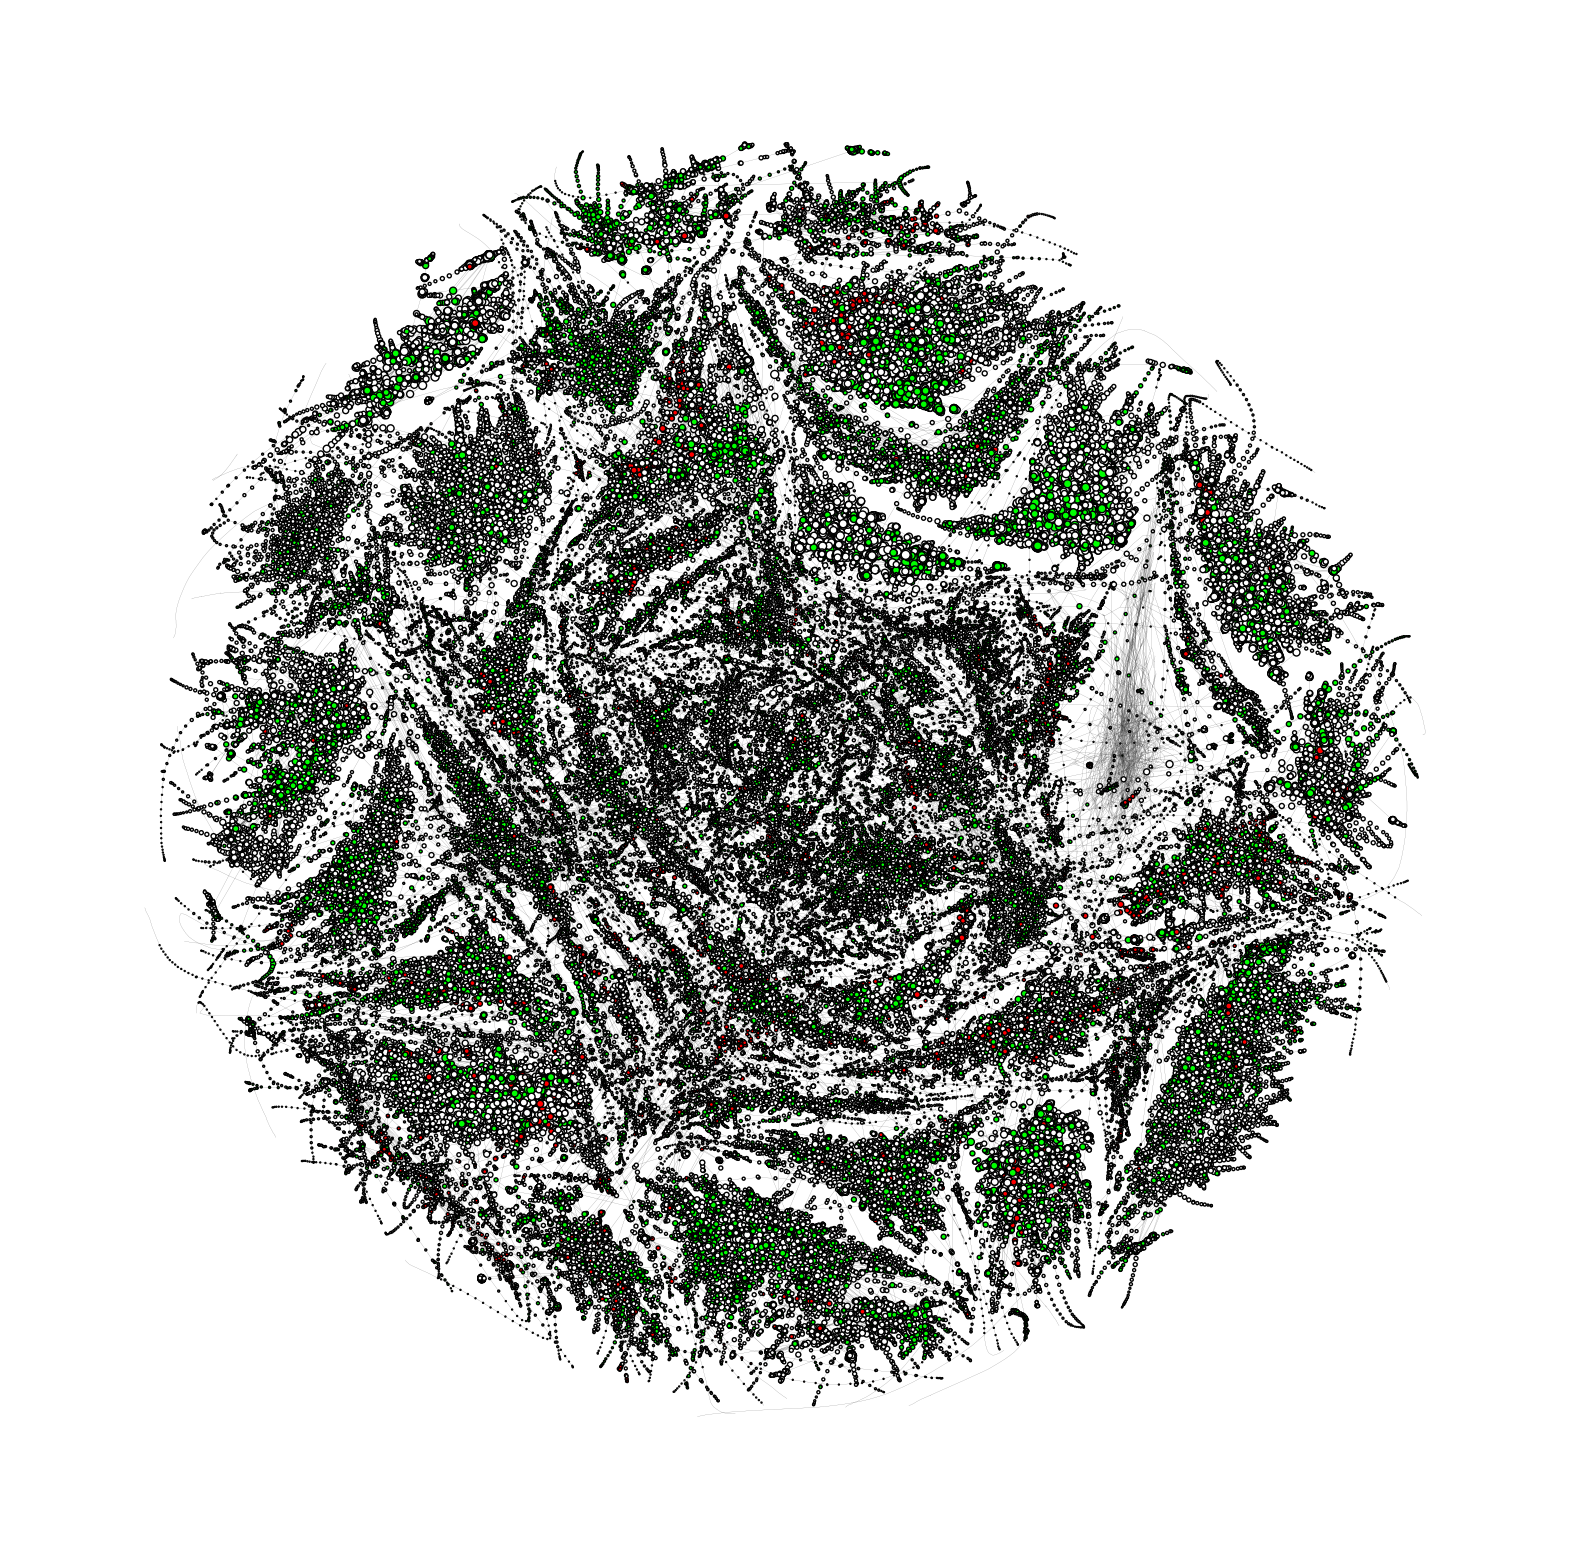

In [22]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20, 20)) 
node_sizes = [c * 50 for c in centralities]
layout = tx_graph.layout_fruchterman_reingold()
ig.plot(tx_graph, vertex_size=node_sizes, edge_width=0.1, bbox=(8000, 8000), margin=50, target=ax)
plt.savefig("large_graph.png", dpi=300)

In [ ]:
import igraph as ig
import matplotlib.pyplot as plt

filtered_vertices = [v.index for v in tx_graph.vs if v['color'] in ['red', 'green']]

filtered_subgraph = tx_graph.subgraph(filtered_vertices)
fig, ax = plt.subplots(figsize=(20, 20)) 

ig.plot(
    filtered_subgraph,
    vertex_size=10,
    edge_width=0.5,
    bbox=(800, 800), 
    margin=50,
    target=ax
)

plt.show()
